In [1]:
# conda env list

# conda create  -n [이름] python=[버전]
# conda activate [이름]

# conda deactivate
# conda remove -n [이름] --all

In [2]:
# 입력-> 토큰화 및 시퀀스 변화 -> 패딩(고정길이화) -> 임베딩(단어->벡터화)-> 1D Convolution + poling 반복
# -> Flatten ->Dense(은닉) -> 출력(소프트맥스, 이진분류) -> 학습(Adam + binary_Crossentropy)
# -> 검증/테스트 평가 -> 시각화

- 말뭉치 로딩(nltk)  데이터 로딩
- 토큰화(빈고 기반 인덱싱) 텍스트를 숫자로 변환
- 시퀀스 패딩   고정길이 배치 구성
- 임베딩  단어를 dense vector표현 학습
- 임베딩  발전
    - 한계 : 작은데이터에서는 일반화 부족
    - 발전 : 사전학습(Word2vec), 문맥적 임베딩(BERT, GPT)

In [3]:
# 토큰화
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# sample data
texts = [
    'I really love this movie',
    'I hate this boring film',
    'love love great film'
]
# 토큰화 객체(최대 단어 10, oov 토큰 지정)
tokenizer = Tokenizer(num_words=10, oov_token='UNK')
tokenizer.fit_on_texts(texts)
print(f'단어인덱스 : {tokenizer.word_index}')
# 시퀀스
seqs = tokenizer.texts_to_sequences(texts)
print(f'원본 시퀀스 : {seqs}')
# 패딩(최대 길이를 6)
padded = pad_sequences(seqs, maxlen=6,padding='post')
print(f'패딩결과 : {padded}  사이즈 : {padded.shape}')


단어인덱스 : {'UNK': 1, 'love': 2, 'i': 3, 'this': 4, 'film': 5, 'really': 6, 'movie': 7, 'hate': 8, 'boring': 9, 'great': 10}
원본 시퀀스 : [[3, 6, 2, 4, 7], [3, 8, 4, 9, 5], [2, 2, 1, 5]]
패딩결과 : [[3 6 2 4 7 0]
 [3 8 4 9 5 0]
 [2 2 1 5 0 0]]  사이즈 : (3, 6)


In [4]:
# 임베딩 : 임베딩 레이어
import tensorflow as tf
# 패딩된 시퀀스  padded
vocab_size = 11  # unk 포함 단어인덱스 최대값 + 1
embed_dim = 4  # 작은 차원
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size,output_dim=embed_dim, input_length=6)    
])
embeddings = model.predict(padded)
print(f'임베딩 텐서 모양 : {embeddings.shape}')  #(3,6,4)
print(f'첫 문장 첫 단어 벡터 : {embeddings[0,0,:]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step

c:\Users\playdata2\miniconda3\envs\deep\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
임베딩 텐서 모양 : (3, 6, 4)
첫 문장 첫 단어 벡터 : [0.0367535  0.03009636 0.04639763 0.00195592]


In [5]:
# 1D Convolution
import numpy as np
import tensorflow as tf
# 임의 시퀀스(배치=1, 길이=6, 임베딩=4)
x = np.random.randn(1,6,4).astype('float32')
conv = tf.keras.layers.Conv1D(
    filters = 2  # 2개의 패턴을 감지  긍정 부정을 감지
    ,kernel_size=3  # 3-gram
    ,activation='relu'  
)
y = conv(x)
print(f'입력 shape {x.shape}')
print(f'출력 shape {y.shape}')
print(f'출력값  {y.numpy()}')

입력 shape (1, 6, 4)
출력 shape (1, 4, 2)
출력값  [[[1.661328   1.8484614 ]
  [0.01489092 0.        ]
  [1.6391318  0.        ]
  [0.         0.        ]]]


In [6]:
# MaxPooling
pool = tf.keras.layers.MaxPooling1D(pool_size=2)
pooled = pool(y)
print(f'before pooling :{y.shape}')
print(f'after pooling :{pooled.shape}')

before pooling :(1, 4, 2)
after pooling :(1, 2, 2)


In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer  # 단어를 단어사전, 단어를 숫자로 변경
from tensorflow.keras.preprocessing.sequence import pad_sequences  #길이 맞추기
texts = [
    'I really love this movie',  # 긍정
    'I hate this boring film',  # 부정
    'great love movie',  # 긍정
    'boring hate film' # 부정
]
labels = np.array([0,1,0,1])

tokenizer = Tokenizer(num_words=50,oov_token='UNK')
tokenizer.fit_on_texts(texts)  # 단어사전 생성
seqs =  tokenizer.texts_to_sequences(texts)  # 단어사전기반으로 단어들을 숫자로 변경(길이는 다름)
x = pad_sequences(seqs,maxlen=6,padding='post')
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(50,8,input_length=6),
    tf.keras.layers.Conv1D(16,3,activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(8,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
history =model.fit(x,labels,epochs=15)

Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - acc: 0.5000 - loss: 0.6911
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - acc: 0.5000 - loss: 0.6902
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - acc: 0.5000 - loss: 0.6893
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - acc: 0.5000 - loss: 0.6884
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - acc: 0.5000 - loss: 0.6875
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - acc: 0.7500 - loss: 0.6866
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - acc: 0.7500 - loss: 0.6857
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - acc: 0.7500 - loss: 0.6847
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - acc: 0.7500 - loss: 0.6835
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - acc: 0.7500 - loss: 0.6824
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - acc: 0.7500 - loss: 0.6814
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - acc: 1.0000 - loss: 0.6804
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - acc: 1.0000

In [8]:
print(f"최종훈련 정확도 : {history.history['acc'][-1]}")
preds = model.predict(x)
print(preds.reshape(-1))
print(f'라벨 : {labels}')

최종훈련 정확도 : 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
[0.49392065 0.5149584  0.49860036 0.5127317 ]
라벨 : [0 1 0 1]


In [9]:
# nltk 데이터로드
import nltk
nltk.download('movie_reviews')
from nltk.corpus import movie_reviews

[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\playdata2\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


In [10]:
# 재현성 시드 고정
import random
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)


In [11]:
# 데이터로딩
ids = movie_reviews.fileids()
reviews = [movie_reviews.raw(id) for id in ids]
categories = [ movie_reviews.categories(id)[0] for id in ids]

In [12]:
# 하이퍼파라메터
max_words = 10000 # 최대단어수
maxlen = 500 # 문서길이
embed_dim = 64 # 임베딩차원
batch_size = 256 # batch_size
epochs = 15 # epoch

# 토큰화 + 시퀀스변화 + 패딩
tokenizer = Tokenizer(num_words=max_words,oov_token='UNK')
tokenizer.fit_on_texts(reviews)
x = tokenizer.texts_to_sequences(reviews)
x = pad_sequences(x,maxlen=maxlen,truncating='post')

# 라벨인코딩
label_map = {'pos':0,'neg':1}
y = np.array([label_map.get(c) for c in categories])
# train/test 분할
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,stratify=y, random_state=42, test_size=0.2)
# 모델구성
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words+1,output_dim=embed_dim,input_length=maxlen),
    tf.keras.layers.Conv1D(128,3,activation='relu'),
    tf.keras.layers.MaxPool1D(),  # 시퀀스의 구간별 특징 요약
    tf.keras.layers.Conv1D(256,3,activation='relu'),
    # tf.keras.layers.GlobalAvgPool1D()  # 전체시퀀스의 평균  시퀀스차원없애고 채널 축만남김(채널에대한평균)
    tf.keras.layers.MaxPool1D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid'),
])
# 컴파일
adam =  tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=adam, loss='binary_crossentropy',metrics=['acc'])
# 콜백(선택)
import tensorflow as  tf
es = tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)
# 학습
history = model.fit(
    x_train,y_train,epochs=epochs,batch_size=batch_size,validation_split = 0.2
    # ,callbacks=[es]
)

Epoch 1/15


c:\Users\playdata2\miniconda3\envs\deep\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 470ms/step - acc: 0.5336 - loss: 0.6982 - val_acc: 0.5437 - val_loss: 0.6901
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 412ms/step - acc: 0.4891 - loss: 0.6949 - val_acc: 0.5437 - val_loss: 0.6925
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 429ms/step - acc: 0.5188 - loss: 0.6923 - val_acc: 0.5188 - val_loss: 0.6926
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 427ms/step - acc: 0.5414 - loss: 0.6909 - val_acc: 0.5562 - val_loss: 0.6903
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 403ms/step - acc: 0.6187 - loss: 0.6893 - val_acc: 0.5188 - val_loss: 0.6900
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 342ms/step - acc: 0.5391 - loss: 0.6868 - val_acc: 0.5188 - val_loss: 0.6919
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 346ms/step - acc: 0.5523 - loss: 0.6811 - val_acc: 0.5250 - val_loss: 0.6906
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 344ms/step - acc: 0.5891 - loss: 0.6714 - val_acc: 0.5281 - val_loss: 0.6892
Epoch 9/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 347ms/step - acc: 0.6570 - loss: 0.6488 - va

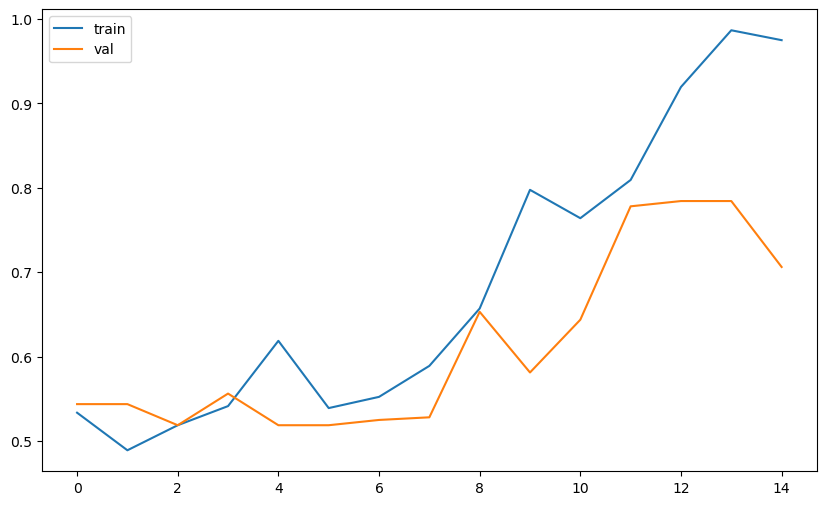

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.6425 - loss: 0.8272
test loss : 0.8271718621253967  test acc : 0.6424999833106995


In [13]:
# 학습결과 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(history.history['acc'],label='train')
plt.plot(history.history['val_acc'], label='val')
plt.legend()
plt.show()
# 테스트 평가
test_loss,  test_acc =  model.evaluate(x_test,y_test)
print(f'test loss : {test_loss}  test acc : {test_acc}')

In [14]:
# 임의의 데이터로 예측
sample_texts = [
    "This movie was absolutely fantastic and inspiring",
    "I really disliked the plot and the acting was terrible"
]
x_sample = tokenizer.texts_to_sequences(sample_texts)
x_sample = pad_sequences(x_sample,maxlen=maxlen,truncating='post')
x_sample_predict = model.predict(x_sample)
x_sample_predict

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


array([[0.94982964],
       [0.9657033 ]], dtype=float32)

In [15]:
#conv1d   배치크기, 시퀀스길이, 채널수
x = tf.random.normal((32,10,64))
print(tf.keras.layers.Flatten()(x).shape)  
tf.keras.layers.GlobalAvgPool1D()(x).shape  # 각 채널 Feature map 마다 평균

(32, 640)


TensorShape([32, 64])

GlobalMaxPooling 사용(파라메터 감소)
- Flatten 대신 GlobalMaxPooling1D 각 필터의 최대값만 추출해서 파라메터수를 감소
- 토크나이져- 시퀀스 - 패딩 --> X   라벨링 --> y
- 분할
- 모델... Flatten  GlobalMaxPool1D

[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\playdata2\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


Epoch 1/14


c:\Users\playdata2\miniconda3\envs\deep\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 446ms/step - acc: 0.5039 - loss: 0.6969 - val_acc: 0.4563 - val_loss: 0.6984
Epoch 2/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 398ms/step - acc: 0.5555 - loss: 0.6850 - val_acc: 0.5625 - val_loss: 0.6926
Epoch 3/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 434ms/step - acc: 0.7484 - loss: 0.6797 - val_acc: 0.4563 - val_loss: 0.6949
Epoch 4/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 405ms/step - acc: 0.5609 - loss: 0.6713 - val_acc: 0.4563 - val_loss: 0.6957
Epoch 5/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 405ms/step - acc: 0.6789 - loss: 0.6602 - val_acc: 0.4563 - val_loss: 0.6934
Epoch 6/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 384ms/step - acc: 0.9445 - loss: 0.6465 - val_acc: 0.4625 - val_loss: 0.6930
Epoch 7/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 388ms/step - acc: 1.0000 - loss: 0.6268 - val_acc: 0.5906 - val_loss: 0.6901
Epoch 8/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 348ms/step - acc: 1.0000 - loss: 0.6009 - val_acc: 0.6656 - val_loss: 0.6876
Epoch 9/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 345ms/step - acc: 1.0000 - loss: 0.5663 - va

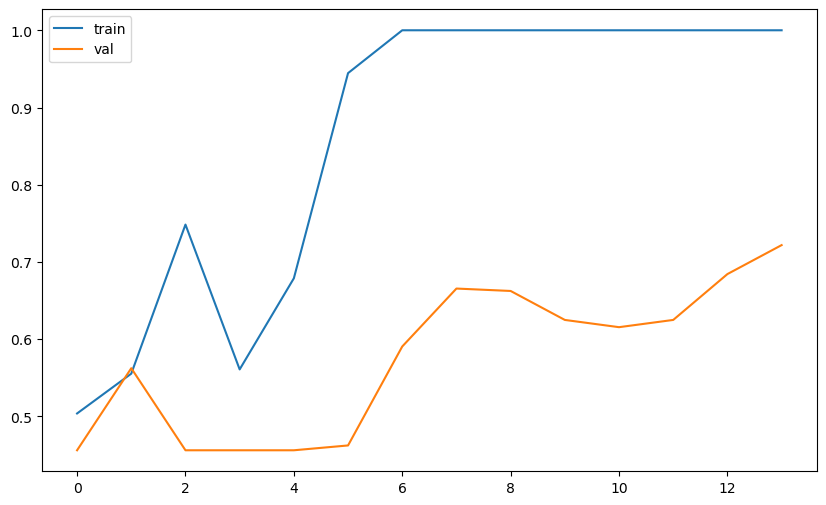

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.7500 - loss: 0.6363
test loss : 0.6362671256065369  test acc : 0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


array([[0.6905892],
       [0.6741922]], dtype=float32)

In [16]:

# nltk 데이터로드
import nltk
nltk.download('movie_reviews')
from nltk.corpus import movie_reviews

# 재현성 시드 고정
import random
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# 데이터로딩
ids = movie_reviews.fileids()
reviews = [movie_reviews.raw(id) for id in ids]
categories = [ movie_reviews.categories(id)[0] for id in ids]

# 하이퍼파라메터
max_words = 10000 # 최대단어수
maxlen = 500 # 문서길이
embed_dim = 64 # 임베딩차원
batch_size = 256 # batch_size
epochs = 14 # epoch

# 토큰화 + 시퀀스변화 + 패딩
tokenizer = Tokenizer(num_words=max_words,oov_token='UNK')
tokenizer.fit_on_texts(reviews)
x = tokenizer.texts_to_sequences(reviews)
x = pad_sequences(x,maxlen=maxlen,truncating='post')

# 라벨인코딩
label_map = {'pos':0,'neg':1}
y = np.array([label_map.get(c) for c in categories])
# train/test 분할
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,stratify=y, random_state=42, test_size=0.2)
# 모델구성
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words+1,output_dim=embed_dim,input_length=maxlen),
    tf.keras.layers.Conv1D(128,3,activation='relu'),
    tf.keras.layers.MaxPool1D(),  # 시퀀스의 구간별 특징 요약
    tf.keras.layers.Conv1D(256,3,activation='relu'),
    tf.keras.layers.GlobalMaxPool1D(),  # 전체시퀀스의 평균  시퀀스차원없애고 채널 축만남김(채널에대한평균)    
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid'),
])
# 컴파일
adam =  tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=adam, loss='binary_crossentropy',metrics=['acc'])
# 콜백(선택)
import tensorflow as  tf
es = tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)
# 학습
history = model.fit(
    x_train,y_train,epochs=epochs,batch_size=batch_size,validation_split = 0.2
    # ,callbacks=[es]
)

# 학습결과 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(history.history['acc'],label='train')
plt.plot(history.history['val_acc'], label='val')
plt.legend()
plt.show()
# 테스트 평가
test_loss,  test_acc =  model.evaluate(x_test,y_test)
print(f'test loss : {test_loss}  test acc : {test_acc}')

# 임의의 데이터로 예측
sample_texts = [
    "This movie was absolutely fantastic and inspiring",
    "I really disliked the plot and the acting was terrible"
]
x_sample = tokenizer.texts_to_sequences(sample_texts)
x_sample = pad_sequences(x_sample,maxlen=maxlen,truncating='post')
x_sample_predict = model.predict(x_sample)
x_sample_predict


- 개선2 다중 커널 크기 병렬 적용(TextCNN)
    - 커널 크기 3 5 7 동시에 사용 다양한 tri-gram  5-gram  7-gram  포착

c:\Users\playdata2\miniconda3\envs\deep\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 597ms/step - acc: 0.5109 - loss: 0.6977 - val_acc: 0.4563 - val_loss: 0.6967
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 523ms/step - acc: 0.7430 - loss: 0.6758 - val_acc: 0.5437 - val_loss: 0.6888
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 513ms/step - acc: 0.9195 - loss: 0.6650 - val_acc: 0.4563 - val_loss: 0.6922
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 505ms/step - acc: 0.7523 - loss: 0.6497 - val_acc: 0.4563 - val_loss: 0.6927
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 498ms/step - acc: 0.9961 - loss: 0.6309 - val_acc: 0.5938 - val_loss: 0.6868
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 524ms/step - acc: 1.0000 - loss: 0.6081 - val_acc: 0.7000 - val_loss: 0.6821
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 600ms/step - acc: 1.0000 - loss: 0.5784 - val_acc: 0.6969 - val_loss: 0.6766
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 590ms/step - acc: 1.0000 - loss: 0.5393 - val_acc: 0.7563 - val_loss: 0.6658
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 601ms/step - acc: 1.0000 - loss: 

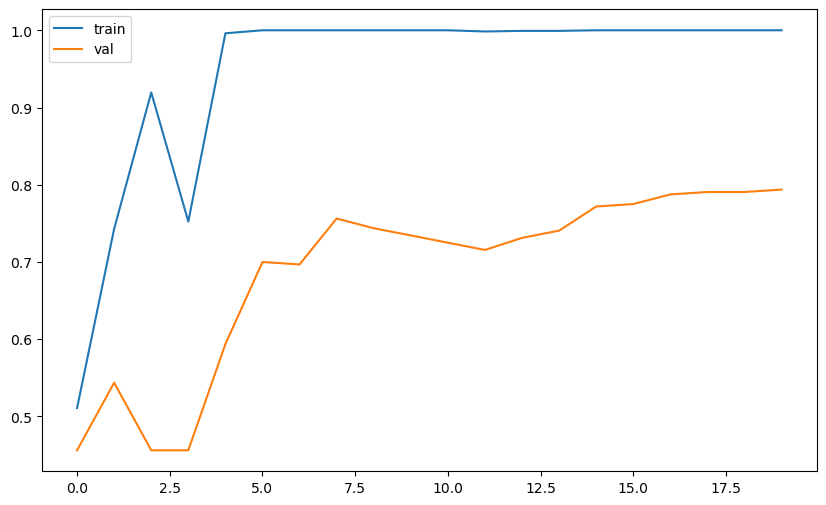

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.7500 - loss: 0.4955
test loss : 0.4954543709754944  test acc : 0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


array([[0.53438425],
       [0.6089997 ]], dtype=float32)

In [ ]:
from tensorflow.keras.layers import Input, Concatenate
# 입력레이어
input_layer = Input(shape=(maxlen ,) ,dtype='int32')
# 임베딩 레이어
embedding = tf.keras.layers.Embedding(max_words+1,embed_dim, input_length = maxlen )(input_layer)
conv_blocks = []
for kener_size in [3,5,7]:
    conv = tf.keras.layers.Conv1D(128,kener_size,activation='relu')(embedding)
    pool = tf.keras.layers.GlobalMaxPool1D()(conv)
    conv_blocks.append(pool)
# 병렬 브랜치 결합
concat = Concatenate()(conv_blocks)
# 완전연결층
dense = tf.keras.layers.Dense(64,activation='relu')(concat)
output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

#모델 생성
model = tf.keras.models.Model(inputs = input_layer, outputs = output)

# 컴파일
adam =  tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=adam, loss='binary_crossentropy',metrics=['acc'])
# 콜백(선택)
import tensorflow as  tf
es = tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)
# 학습
history = model.fit(
    x_train,y_train,epochs=20,batch_size=batch_size,validation_split = 0.2
    # ,callbacks=[es]
)

# 학습결과 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(history.history['acc'],label='train')
plt.plot(history.history['val_acc'], label='val')
plt.legend()
plt.show()
# 테스트 평가
test_loss,  test_acc =  model.evaluate(x_test,y_test)
print(f'test loss : {test_loss}  test acc : {test_acc}')

# 임의의 데이터로 예측
sample_texts = [
    "This movie was absolutely fantastic and inspiring",
    "I really disliked the plot and the acting was terrible"
]
x_sample = tokenizer.texts_to_sequences(sample_texts)
x_sample = pad_sequences(x_sample,maxlen=maxlen,truncating='post')
x_sample_predict = model.predict(x_sample)
x_sample_predict

Pretrained Embeddings (GloVe) 로 초기화

In [18]:
# import os
# import urllib.request
# import zipfile
# glove_url = 'https://nlp.stanford.edu/data/glove.6B.zip'
# glove_dir = './glove_data'
# glove_file = os.path.join(glove_dir, 'glove.6B.100d.txt')

# if not os.path.exists(glove_file):
#     os.makedirs(glove_dir, exist_ok=True)
#     zip_path = os.path.join(glove_dir, 'glove.6B.zip')
#     urllib.request.urlretrieve(glove_url, zip_path)
#     with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#         zip_ref.extractall(glove_dir)
#     print("다운로드 완료!")

In [19]:
# %conda install gensim

In [20]:
import gensim.downloader as api
import numpy as np
wv = api.load('glove-wiki-gigaword-50')

In [21]:
# 우리 데이터셋에서 사용되는 단어들 을
# GloVe가 이미 학습한 벡터 로 연결해서
# Embedding Layer 의 가중치 초기값으로 사용하기 위해 embedding_matrix를 만드는 것.
wv['king'].shape

(50,)

매칭 : 9722 비매칭 : 277
커버리지 : 0.9722972297229723
Epoch 1/100


c:\Users\playdata2\miniconda3\envs\deep\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - acc: 0.5125 - loss: 0.7836 - val_acc: 0.5437 - val_loss: 0.7286
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 855ms/step - acc: 0.4758 - loss: 0.7476 - val_acc: 0.4563 - val_loss: 0.7490
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 566ms/step - acc: 0.5852 - loss: 0.6709 - val_acc: 0.5437 - val_loss: 0.6975
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 493ms/step - acc: 0.5344 - loss: 0.6762 - val_acc: 0.4563 - val_loss: 0.7137
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 522ms/step - acc: 0.5555 - loss: 0.6476 - val_acc: 0.5781 - val_loss: 0.6839
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 508ms/step - acc: 0.7633 - loss: 0.6323 - val_acc: 0.5938 - val_loss: 0.6838
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 500ms/step - acc: 0.8109 - loss: 0.6168 - val_acc: 0.5188 - val_loss: 0.6856
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 503ms/step - acc: 0.9742 - loss: 0.5967 - val_acc: 0.5969 - val_loss: 0.6766
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 507ms/step - acc: 0.9336 - loss: 0.5831

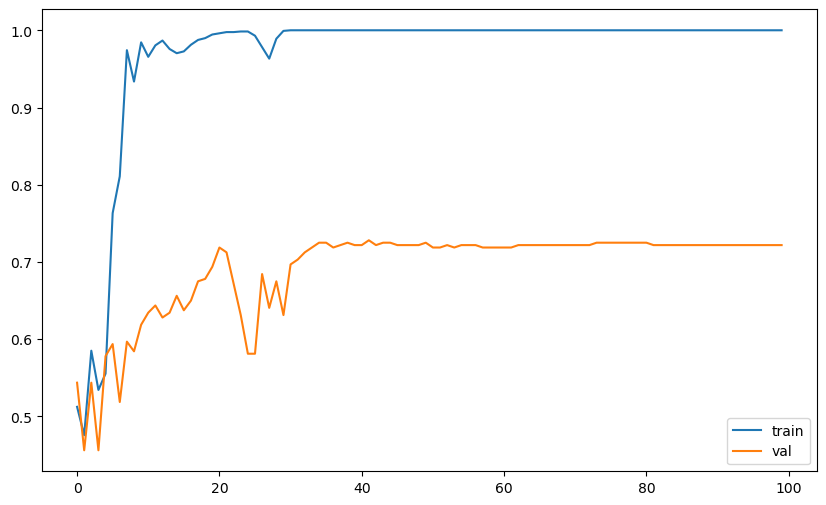

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - acc: 0.7700 - loss: 0.6096
test loss : 0.6096146106719971  test acc : 0.7699999809265137
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


array([[0.49687707],
       [0.7419503 ]], dtype=float32)

In [24]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer  # 단어를 단어사전, 단어를 숫자로 변경
from tensorflow.keras.preprocessing.sequence import pad_sequences  #길이 맞추기 

# 하이퍼파라메터
max_words = 10000 # 최대단어수
maxlen = 500 # 문서길이
embed_dim = 50 # 임베딩차원
batch_size = 256 # batch_size
epochs = 15 # epoch

# 토큰화 + 시퀀스변화 + 패딩
tokenizer = Tokenizer(num_words=max_words,oov_token='UNK')
tokenizer.fit_on_texts(reviews)
x = tokenizer.texts_to_sequences(reviews)
x = pad_sequences(x,maxlen=maxlen,truncating='post')

# 라벨인코딩
label_map = {'pos':0,'neg':1}
y = np.array([label_map.get(c) for c in categories])
# train/test 분할
from sklearn.model_selection import train_test_split
import numpy as np
x_train,x_test,y_train,y_test = train_test_split(x,y,stratify=y, random_state=42, test_size=0.2)

# 임베딩 매트릭스 초기화
word_index = tokenizer.word_index
num_words = min(max_words, len(word_index)+1)
embedding_matrix = np.random.normal(
    loc = 0.0, scale=0.1,size =(num_words, embed_dim)
)

# glove 매칭
hits = 0
misses = 0
for word, i in word_index.items():
    if i >= max_words:
        continue
    try:
        embedding_vector = wv[word]      # GloVe에서 단어 벡터 찾기
        embedding_matrix[i] = embedding_vector  # 해당 위치에 저장
        hits += 1
    except KeyError:
        misses += 1
print(f'매칭 : {hits} 비매칭 : {misses}')        
print(f'커버리지 : {hits / (hits+misses)}')

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(num_words,output_dim=embed_dim,input_length=maxlen,
                              weights=[embedding_matrix] ),
    tf.keras.layers.Conv1D(128,3,activation='relu'),
    tf.keras.layers.MaxPool1D(),  # 시퀀스의 구간별 특징 요약
    tf.keras.layers.Conv1D(256,3,activation='relu'),
    tf.keras.layers.GlobalMaxPool1D(),  # 전체시퀀스의 평균  시퀀스차원없애고 채널 축만남김(채널에대한평균)    
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid'),
])
# 컴파일
adam =  tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=adam, loss='binary_crossentropy',metrics=['acc'])
# 콜백(선택)
import tensorflow as  tf
es = tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)
# 학습
history = model.fit(
    x_train,y_train,epochs=100,batch_size=batch_size,validation_split = 0.2
    # ,callbacks=[es]
)

# 학습결과 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(history.history['acc'],label='train')
plt.plot(history.history['val_acc'], label='val')
plt.legend()
plt.show()
# 테스트 평가
test_loss,  test_acc =  model.evaluate(x_test,y_test)
print(f'test loss : {test_loss}  test acc : {test_acc}')

# 임의의 데이터로 예측
sample_texts = [
    "This movie was absolutely fantastic and inspiring",
    "I really disliked the plot and the acting was terrible"
]
x_sample = tokenizer.texts_to_sequences(sample_texts)
x_sample = pad_sequences(x_sample,maxlen=maxlen,truncating='post')
x_sample_predict = model.predict(x_sample)
x_sample_predict

다중커널(3 5 7) + 드랍아웃 + L2 정규화


c:\Users\playdata2\miniconda3\envs\deep\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 827ms/step - acc: 0.5219 - loss: 1.0043 - val_acc: 0.4563 - val_loss: 0.9822
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 715ms/step - acc: 0.5844 - loss: 0.9543 - val_acc: 0.5844 - val_loss: 0.9413
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 713ms/step - acc: 0.6906 - loss: 0.9163 - val_acc: 0.4563 - val_loss: 0.9111
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 719ms/step - acc: 0.7047 - loss: 0.8804 - val_acc: 0.4563 - val_loss: 0.8844
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 761ms/step - acc: 0.7391 - loss: 0.8468 - val_acc: 0.4625 - val_loss: 0.8589
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 711ms/step - acc: 0.8672 - loss: 0.8184 - val_acc: 0.4844 - val_loss: 0.8378
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 709ms/step - acc: 0.8984 - loss: 0.7918 - val_acc: 0.5063 - val_loss: 0.8204
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 713ms/step - acc: 0.9469 - loss: 0.7689 - val_acc: 0.5813 - val_loss: 0.8049
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 725ms/step - acc: 0.9875 - loss: 

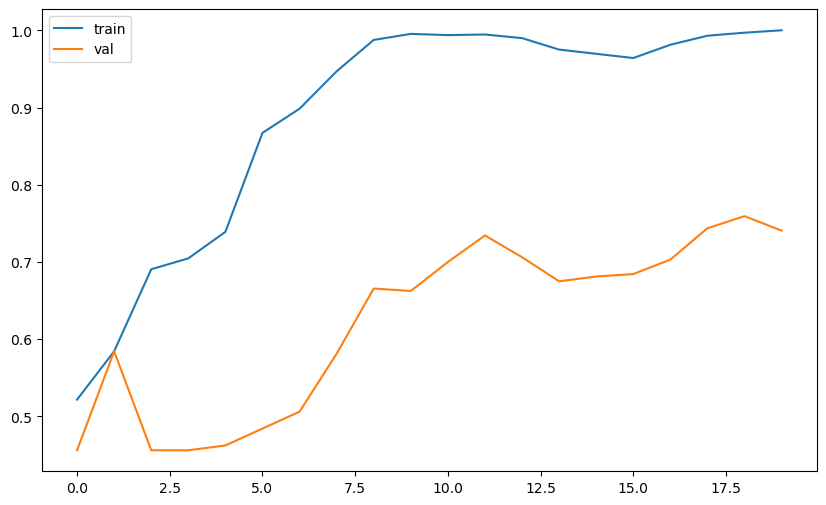

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - acc: 0.7500 - loss: 0.6447
test loss : 0.6446958780288696  test acc : 0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


array([[0.37250888],
       [0.51673245]], dtype=float32)

In [26]:
from tensorflow.keras.layers import Input, Concatenate
# 입력레이어
input_layer = Input(shape=(maxlen ,) ,dtype='int32')
# 임베딩 레이어
embedding = tf.keras.layers.Embedding(max_words+1,embed_dim, input_length = maxlen )(input_layer)
conv_blocks = []
for kener_size in [3,5,7]:
    conv = tf.keras.layers.Conv1D(
        128,
        kener_size,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(1e-3),
        )(embedding)
    pool = tf.keras.layers.GlobalMaxPool1D()(conv)
    conv_blocks.append(pool)
# 병렬 브랜치 결합
concat = Concatenate()(conv_blocks)
# 완전연결층
dense = tf.keras.layers.Dense(128,activation='relu',
                              kernel_regularizer=tf.keras.regularizers.l2(1e-3),
                              )(concat)
dense = tf.keras.layers.Dropout(0.5)(dense)
dense = tf.keras.layers.Dense(64,activation='relu',
                              kernel_regularizer=tf.keras.regularizers.l2(1e-3),
                              )(concat)
dense = tf.keras.layers.Dropout(0.3)(dense)
output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

#모델 생성
model = tf.keras.models.Model(inputs = input_layer, outputs = output)

# 컴파일
adam =  tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=adam, loss='binary_crossentropy',metrics=['acc'])
# 콜백(선택)
import tensorflow as  tf
es = tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)
# 학습
history = model.fit(
    x_train,y_train,epochs=20,batch_size=batch_size,validation_split = 0.2
    # ,callbacks=[es]
)

# 학습결과 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(history.history['acc'],label='train')
plt.plot(history.history['val_acc'], label='val')
plt.legend()
plt.show()
# 테스트 평가
test_loss,  test_acc =  model.evaluate(x_test,y_test)
print(f'test loss : {test_loss}  test acc : {test_acc}')

# 임의의 데이터로 예측
sample_texts = [
    "This movie was absolutely fantastic and inspiring",
    "I really disliked the plot and the acting was terrible"
]
x_sample = tokenizer.texts_to_sequences(sample_texts)
x_sample = pad_sequences(x_sample,maxlen=maxlen,truncating='post')
x_sample_predict = model.predict(x_sample)
x_sample_predict

In [40]:
import numpy as np; np.random.seed(1234)
import pandas as pd


ntrain = 150000

data = pd.read_csv('ratings.txt', sep='\t', quoting=3)
data = pd.DataFrame(np.random.permutation(data))
reviews = data[1].values

In [41]:
# 하이퍼파라메터
max_words = 10000 # 최대단어수
maxlen = 500 # 문서길이
embed_dim = 64 # 임베딩차원
batch_size = 256 # batch_size
epochs = 15 # epoch

# 토큰화 + 시퀀스변화 + 패딩
tokenizer = Tokenizer(num_words=max_words,oov_token='UNK')
tokenizer.fit_on_texts(reviews)
x = tokenizer.texts_to_sequences(reviews)
x = pad_sequences(x,maxlen=maxlen,truncating='post')

# 라벨인코딩
label_map = {'pos':0,'neg':1}
y = np.array([label_map.get(c) for c in categories])
# train/test 분할
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,stratify=y, random_state=42, test_size=0.2)
# 모델구성
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words+1,output_dim=embed_dim,input_length=maxlen),
    tf.keras.layers.Conv1D(128,3,activation='relu'),
    tf.keras.layers.MaxPool1D(),  # 시퀀스의 구간별 특징 요약
    tf.keras.layers.Conv1D(256,3,activation='relu'),
    # tf.keras.layers.GlobalAvgPool1D()  # 전체시퀀스의 평균  시퀀스차원없애고 채널 축만남김(채널에대한평균)
    tf.keras.layers.MaxPool1D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid'),
])
# 컴파일
adam =  tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=adam, loss='binary_crossentropy',metrics=['acc'])
# 콜백(선택)
import tensorflow as  tf
es = tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)
# 학습
history = model.fit(
    x_train,y_train,epochs=epochs,batch_size=batch_size,validation_split = 0.2
    # ,callbacks=[es]
)

AttributeError: 'float' object has no attribute 'lower'